In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv('all_matches.csv')

In [12]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Scotland,False


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50323 entries, 0 to 50322
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        50323 non-null  object
 1   home_team   50323 non-null  object
 2   away_team   50323 non-null  object
 3   home_score  50323 non-null  int64 
 4   away_score  50323 non-null  int64 
 5   tournament  50323 non-null  object
 6   country     50323 non-null  object
 7   neutral     50323 non-null  bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 2.7+ MB


# 1. Modèle de Prédiction des Résultats de Matchs
➡ But : Prédire l'issue des matchs (victoire, nul, défaite) en fonction de divers facteurs (lieu du match, historique des équipes, compétition, etc.).

➡ Méthodes :

Régression logistique ou modèles de machine learning (Random Forest, XGBoost).
Deep Learning avec un réseau de neurones.


## Préparation des Données
Nettoyage du dataset (gestion des valeurs manquantes, format des dates, etc.).

Feature engineering : création de variables comme la forme récente des équipes, le classement Elo, l’avantage du terrain est une donnée déjà présente dans notre tableau.

Encodage des variables catégorielles (ex: noms des équipes).

Pourquoi créer des variables supplémentaire et un classement elo ? Cela va nous permettre d'avoir de bons indicateurs respectivement de forme et de force d’une équipe. 
Ces variables évolurons après chaque match et nous permettrons d'avoir des données subjectivement pertinentes à notre modèle de prédiction. 

On crée alors :

- Nombre de victoires/nuls/défaites sur les 5 derniers matchs.

- Nombre de buts marqués/encaissés sur les 5 derniers matchs.

- Moyenne des points pris (3 pour une victoire, 1 pour un nul, 0 pour une défaite).

Puis notre classement elo calculé avec cette formule : $$
{\displaystyle R_{new}=R_{old}* K * (S-E)}
$$tels que : 

(cf. https://fr.wikipedia.org/wiki/Classement_Elo)
- S = 1 pour une victoire, 0.5 pour un nul, 0 pour une défaite.
- $$
{\displaystyle E={\frac {1}{1+10^{\frac {-D}{400}}}}}
$$
-𝐾 est un facteur d’ajustement ("Le coefficient est appelé coefficient de développement. Il vaut 40 pour les 30 premières parties, 20 tant que le joueur est en dessous de 2 400 points Elo, 10 s'il est au-dessus." Pour le classement échéquien.) Nous le fixerons à 20 dans notre cas. 

In [29]:
# Charger les données (si ce n'est pas déjà fait)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['date'])

# Créer une version longue du dataset (une ligne par équipe par match)
df_long = pd.melt(df, id_vars=['date', 'tournament', 'country', 'neutral', 'home_score', 'away_score'],
                  value_vars=['home_team', 'away_team'],
                  var_name='location', value_name='team')

# Ajouter les scores correspondants
df_long['goals_scored'] = df_long.apply(lambda row: row['home_score'] if row['location'] == 'home_team' else row['away_score'], axis=1)
df_long['goals_conceded'] = df_long.apply(lambda row: row['away_score'] if row['location'] == 'home_team' else row['home_score'], axis=1)

# Définir la victoire, le nul ou la défaite
df_long['win'] = df_long.apply(lambda row: 1 if row['goals_scored'] > row['goals_conceded'] else 0, axis=1)
df_long['draw'] = df_long.apply(lambda row: 1 if row['goals_scored'] == row['goals_conceded'] else 0, axis=1)
df_long['loss'] = df_long.apply(lambda row: 1 if row['goals_scored'] < row['goals_conceded'] else 0, axis=1)

# Calculer la forme récente (moyenne mobile sur les 5 derniers matchs)
df_long = df_long.sort_values(by=['team', 'date'])
df_long['last_5_wins'] = df_long.groupby('team')['win'].rolling(5).sum().reset_index(0, drop=True)
df_long['last_5_goals_scored'] = df_long.groupby('team')['goals_scored'].rolling(5).mean().reset_index(0, drop=True)
df_long['last_5_goals_conceded'] = df_long.groupby('team')['goals_conceded'].rolling(5).mean().reset_index(0, drop=True)

# Remettre les valeurs NaN à 0 (si une équipe a joué moins de 5 matchs)
df_long[['last_5_wins', 'last_5_goals_scored', 'last_5_goals_conceded']] = df_long[['last_5_wins', 'last_5_goals_scored', 'last_5_goals_conceded']].fillna(0)

# Afficher le head pour vérifier
df_long.head()


,date,tournament,country,neutral,home_score,away_score,location,team,goals_scored,goals_conceded,win,draw,loss,last_5_wins,last_5_goals_scored,last_5_goals_conceded
57425,1965-09-02,Pan Arab Games,Egypt,True,1,0,away_team,Aden,0,1,0,0,1,0.0,0.0,0.0
57428,1965-09-03,Pan Arab Games,Egypt,False,14,0,away_team,Aden,0,14,0,0,1,0.0,0.0,0.0
57435,1965-09-04,Pan Arab Games,Egypt,True,6,0,away_team,Aden,0,6,0,0,1,0.0,0.0,0.0
57441,1965-09-07,Pan Arab Games,Egypt,True,4,3,away_team,Aden,3,4,0,0,1,0.0,0.0,0.0
2755,1941-08-24,Friendly tournament,Afghanistan,False,0,0,home_team,Afghanistan,0,0,0,1,0,0.0,0.0,0.0


In [30]:
import pandas as pd

# Initialiser le dictionnaire des classements Elo
elo_ratings = {}

# Fonction pour calculer la probabilité de gagner
def expected_result(elo_A, elo_B):
    return 1 / (1 + 10 ** ((elo_B - elo_A) / 400))

# Fonction pour mettre à jour l'Elo
def update_elo(winner_elo, loser_elo, result, k=20):
    expected_win = expected_result(winner_elo, loser_elo)
    new_winner_elo = winner_elo + k * (result - expected_win)
    new_loser_elo = loser_elo + k * ((1 - result) - (1 - expected_win))
    return new_winner_elo, new_loser_elo

# Ajout des Elo dans df_long
elo_history = []

for index, row in df.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    home_score = row['home_score']
    away_score = row['away_score']

    # Initialiser les Elo si l'équipe est nouvelle
    if home_team not in elo_ratings:
        elo_ratings[home_team] = 1500
    if away_team not in elo_ratings:
        elo_ratings[away_team] = 1500

    # Récupérer les scores actuels
    home_elo = elo_ratings[home_team]
    away_elo = elo_ratings[away_team]

    # Déterminer le résultat du match
    if home_score > away_score:
        home_result, away_result = 1, 0  # Victoire home, défaite away
    elif home_score < away_score:
        home_result, away_result = 0, 1  # Défaite home, victoire away
    else:
        home_result, away_result = 0.5, 0.5  # Match nul

    # Mettre à jour les Elo
    new_home_elo, new_away_elo = update_elo(home_elo, away_elo, home_result)

    # Stocker l'historique Elo
    elo_history.append({'date': row['date'], 'team': home_team, 'elo': home_elo})
    elo_history.append({'date': row['date'], 'team': away_team, 'elo': away_elo})

    # Appliquer les nouveaux classements
    elo_ratings[home_team] = new_home_elo
    elo_ratings[away_team] = new_away_elo

# Convertir en DataFrame
elo_df = pd.DataFrame(elo_history)

# Fusionner avec df_long
df_long = df_long.merge(elo_df, on=['date', 'team'], how='left')

# Vérifier le head
df_long.head()

,date,tournament,country,neutral,home_score,away_score,location,team,goals_scored,goals_conceded,win,draw,loss,last_5_wins,last_5_goals_scored,last_5_goals_conceded,elo
0,1965-09-02,Pan Arab Games,Egypt,True,1,0,away_team,Aden,0,1,0,0,1,0.0,0.0,0.0,1500.000000
1,1965-09-03,Pan Arab Games,Egypt,False,14,0,away_team,Aden,0,14,0,0,1,0.0,0.0,0.0,1488.296343
2,1965-09-04,Pan Arab Games,Egypt,True,6,0,away_team,Aden,0,6,0,0,1,0.0,0.0,0.0,1482.119186
3,1965-09-07,Pan Arab Games,Egypt,True,4,3,away_team,Aden,3,4,0,0,1,0.0,0.0,0.0,1473.512232
4,1941-08-24,Friendly tournament,Afghanistan,False,0,0,home_team,Afghanistan,0,0,0,1,0,0.0,0.0,0.0,1500.000000


Pour illustrer les élos, nous allons représenter un graphique ci-dessous avec les elos des équipes suivante : Brésil, France et Angleterre. Nous pouvons remarquer que durant les temps des deux guerres mondiales l'élo de l'équipe anglaise est stable.

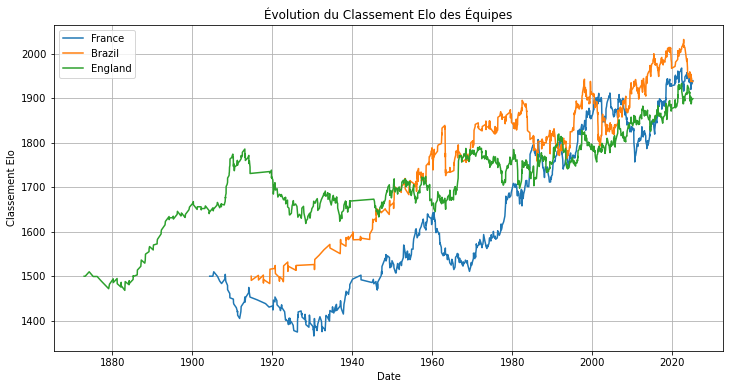

In [32]:
teams = ['France', 'Brazil', 'England']
df_plot = df_long[df_long['team'].isin(teams)]

plt.figure(figsize=(12, 6))

for team in teams:
    subset = df_plot[df_plot['team'] == team]
    plt.plot(subset['date'], subset['elo'], label=team)

plt.xlabel('Date')
plt.ylabel('Classement Elo')
plt.title("Évolution du Classement Elo des Équipes")
plt.legend()
plt.grid()

plt.show()

## 2. Analyse Exploratoire (EDA)
Distribution des résultats (combien de victoires, nuls, défaites ?).

Influence de certaines variables (ex: taux de victoires à domicile).

Corrélations entre variables.


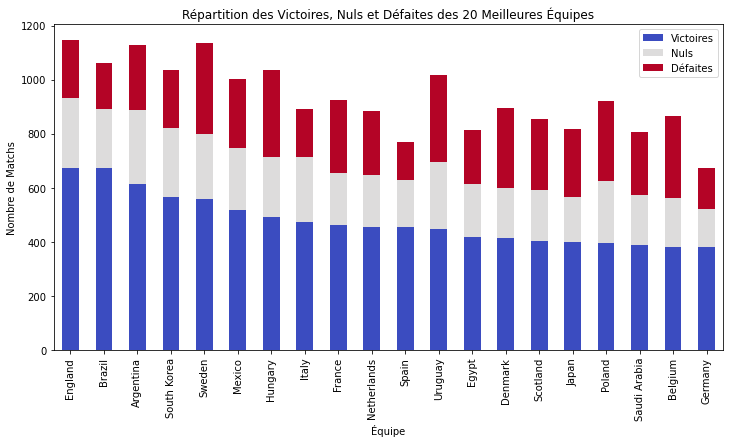

In [35]:

# Calcul des stats par équipe
team_results = df_long.groupby('team')[['win', 'draw', 'loss']].sum()

# Affichage en barplot
team_results.sort_values(by='win', ascending=False).head(20).plot(
    kind='bar', stacked=True, figsize=(12, 6), colormap="coolwarm")

plt.title("Répartition des Victoires, Nuls et Défaites des 20 Meilleures Équipes")
plt.xlabel("Équipe")
plt.ylabel("Nombre de Matchs")
plt.legend(["Victoires", "Nuls", "Défaites"])
plt.xticks(rotation=90)
plt.show()

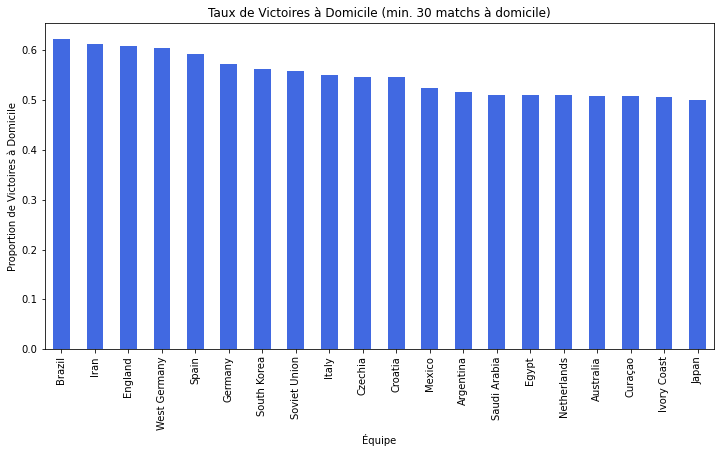

In [37]:
# Calcul du nombre total de matchs joués à domicile et en terrain neutre
home_matches = df_long[df_long['neutral'] == False].groupby('team')['win'].count()
neutral_matches = df_long[df_long['neutral'] == True].groupby('team')['win'].count()

# Calcul du taux de victoire à domicile
win_ratio = home_wins / home_matches

# Filtrage : on garde les équipes avec au moins 30 matchs à domicile pour éviter les biais car les petites équipes
# peuvent avoir une probabilité de victoire de 100% en jouant queques matchs à domicile.
win_ratio = win_ratio[home_matches >= 30]

# Affichage du top 20 des équipes les plus avantagées par le domicile
win_ratio.sort_values(ascending=False).head(20).plot(kind='bar', figsize=(12, 6), color='royalblue')

plt.title("Taux de Victoires à Domicile (min. 30 matchs à domicile)")
plt.xlabel("Équipe")
plt.ylabel("Proportion de Victoires à Domicile")
plt.xticks(rotation=90)
plt.show()


On va comparer le taux de victoire à domicile avant et après l’an 2000 pour voir si l’avantage du terrain a changé avec le temps.

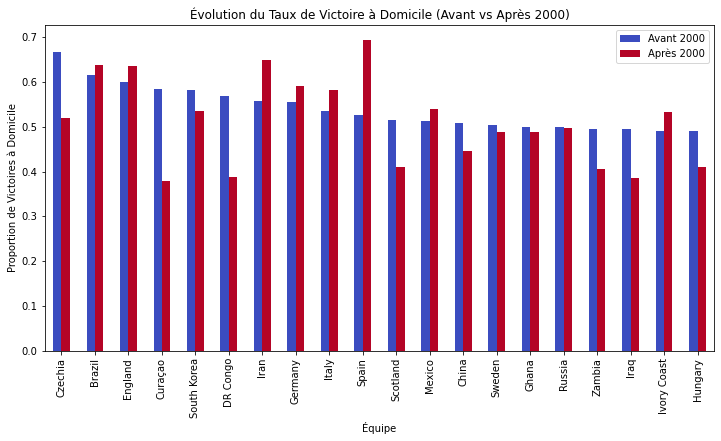

In [38]:
# Création des datasets avant et après 2000
df_before_2000 = df_long[(df_long['neutral'] == False) & (df_long['date'] < '2000-01-01')]
df_after_2000 = df_long[(df_long['neutral'] == False) & (df_long['date'] >= '2000-01-01')]

home_wins_before = df_before_2000.groupby('team')['win'].sum()
home_matches_before = df_before_2000.groupby('team')['win'].count()

home_wins_after = df_after_2000.groupby('team')['win'].sum()
home_matches_after = df_after_2000.groupby('team')['win'].count()

win_ratio_before = home_wins_before / home_matches_before
win_ratio_after = home_wins_after / home_matches_after

# Filtrage : on garde les équipes avec au moins 30 matchs à domicile dans les deux périodes
valid_teams = home_matches_before[(home_matches_before >= 30) & (home_matches_after >= 30)].index

win_ratio_before = win_ratio_before.loc[valid_teams]
win_ratio_after = win_ratio_after.loc[valid_teams]

# Création du DataFrame pour comparaison
win_comparison = pd.DataFrame({'Avant 2000': win_ratio_before, 'Après 2000': win_ratio_after}).dropna()

# Affichage du graphique
win_comparison.sort_values('Avant 2000', ascending=False).head(20).plot(kind='bar', figsize=(12, 6), colormap="coolwarm")

plt.title("Évolution du Taux de Victoire à Domicile (Avant vs Après 2000)")
plt.xlabel("Équipe")
plt.ylabel("Proportion de Victoires à Domicile")
plt.xticks(rotation=90)
plt.legend(["Avant 2000", "Après 2000"])
plt.show()


On voit de réelles différences chez certains pays comme le DR Congo ou le Curaçao avec une chute du taux de victoires après les années 2000. En revanche certains pays se sont davantage renforcés en taux de victoires comme l'Espagne qui a eu une période très victorieuse des années 2008 à 2012. On peut aussi dire qu'un taux au dessus des 60% montre un avantange particulièrement fort du terrain comme donc pour l'Iran, le Brésil, l'Angleterre ou encore l'Espagne.


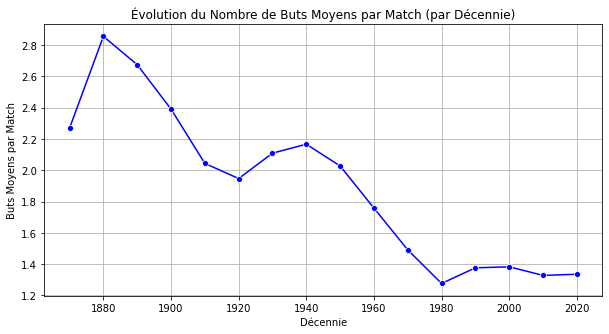

In [56]:
# Création d'une colonne 'décennie'
df_long['decade'] = (df_long['date'].dt.year // 10) * 10

# Moyenne des buts par décennie
decade_goals = df_long.groupby('decade')['goals_scored'].mean()

# Affichage
plt.figure(figsize=(10, 5))
sns.lineplot(x=decade_goals.index, y=decade_goals.values, marker='o', color="blue")
plt.title("Évolution du Nombre de Buts Moyens par Match (par Décennie)")
plt.xlabel("Décennie")
plt.ylabel("Buts Moyens par Match")
plt.grid()
plt.show()


On peut voir ici que les matchs avant les années 60 etaient beaucoup plus ciblés sur l'offensivité des équipes. Ça peut indiquer que le football est devenu plus tactique et défensif.